In [10]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt
import torch
from fairseq.models.wav2vec import Wav2VecdecoderModel, Wav2VecAutoEncoderModel

In [11]:
# ./w2v_thn/decoder/0118like_en_arch/checkpoint_last.pt
# './w2v_thn/0119_big_lr/checkpoint_best.pt'
# './w2v_thn/decoder/0119_big_lr_small_sample/checkpoint_last.pt'
# cp = torch.load('./w2v_thn/decoder/0221_1_act_tanh_time_div4_feat8_6dB_MSE/checkpoint_best.pt')
cp = torch.load('./w2v_thn/Rice_decoder/0623_tanh_tdiv1_feat8_6dB_Rice0_8_NR/checkpoint_last.pt')

model = Wav2VecAutoEncoderModel.build_model(cp['cfg']['model'], task=None)
model.load_state_dict(cp['model'])
model.eval()

Wav2VecAutoEncoderModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): ConvTranspose1d(8, 8, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (1): Sequential(
        (0): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (2): Sequential(
        (0): ConvTranspose1d(8, 8, kernel_size=(4,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
      )
      (3): Sequential(
        (0): ConvTranspose1d(8, 1, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Tanh()
      )
    )
  )
  (feature_aggregator): ConvAggegator(
    (conv_layers): Sequential(
      (0): Seq

In [4]:
Para = cp['model']

#### 加载embedding

In [12]:
# import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt

fname = '/home/thn/audio_dataset/LibriSpeech/embedding_output/d0115/116-288045-0000.txt'
# sub_fame = fname.split('/')[-1].split('.')[0]
emb = np.loadtxt(fname)
feats = torch.from_numpy(emb).float().view(1, -1, 512).transpose(1, 2)

# wav, curr_sample_rate = sf.read(fname)
# feats = torch.from_numpy(wav).float()

###  加载音频

In [13]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt

fname = '/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/116-288045-0001.flac'
# fname = '/home/thn/audio_dataset/LibriSpeech/dev-clean/174/50561/174-50561-0000.flac'

wav, curr_sample_rate = sf.read(fname)
# feats = torch.from_numpy(wav).float()
wav_t = wav *5 /3 + 0.5
source = torch.from_numpy(wav).float().view(1, -1)

In [9]:
source.shape

torch.Size([1, 170400])

## 2. Pass model

In [12]:
SNR = 6
import math
N = 0.2 /math.sqrt(10**(SNR/10))
N

0.10023744672545447

In [15]:
[r1,r2,r3] = X.shape
P_noise = 0.2 /math.sqrt(10**(SNR/10))
noise = np.random.randn(r1,r2,r3)
Y = X + torch.from_numpy(noise) * P_noise

In [69]:
# Encoder, Transmitter 
source_ = source 
T_a = model.feature_extractor_en(source_)
T_a_ = model.dropout_feats_en(T_a)
print("|*****T_a_S:|", T_a_.shape)
X = model.feature_aggregator_en(T_a_)
X = model.dropout_agg_en(X)
print("|*******X_S:|", X.shape)

# Channel layer

import math
import numpy as np
SNR = 12 # dB # SNR = 10 log（s/n） = 6
P_noise = 0.2 /math.sqrt(10**(SNR/10))
P_noise = torch.tensor(P_noise).half()
# [r1,r2,r3] = X.shape 
# noise = np.random.randn(r1,r2,r3)
noise = torch.randn(X.shape).half()
# print(X.type(), torch.from_numpy(noise).float().cuda().type(), P_noise.type())
# Y = X + torch.from_numpy(noise).half().cuda() * P_noise.cuda()
Y =  0.1 * ( X + noise * P_noise)

# —————————— No Noise Channel ————————-
# Y  = X

# ——————————  Decoder, Receiver ———————
print("In the Channel Y_S", Y.shape)
features = model.feature_aggregator(Y)
# x = self.dropout_agg(feature)

features_ = model.dropout_agg(features)
x = model.feature_extractor(features_)
print("|in decoder model, out feature_extractor|", x.shape)
x_ = model.dropout_feats(x)
# x_ = x_ - 1

|*****T_a_S:| torch.Size([1, 8, 138156])
|*******X_S:| torch.Size([1, 8, 138156])
In the Channel Y_S torch.Size([1, 8, 138156])
|in decoder model, out feature_extractor| torch.Size([1, 1, 138160])


In [15]:
#  定义绘制一维向量的函数
def plot_curve(y: np.ndarray, i = 0, j = 0) -> None:
    import matplotlib.pyplot as plt
    import matplotlib
    x = np.arange(0,len(y))
    if j == 0: 
        j = len(y)      
    # i = 10000
    # l = 50000
    plt.figure(1)
    plt.plot(x[i: i + j], y[i: i + j],'k',color='#696969', linewidth=0.4, linestyle="-") 
    plt.rcParams['figure.figsize'] = (50.0, 10.0) # 设置figure_size尺寸
    plt.grid(ls='--')#标尺，on：有，off:无。
#     plt.savefig('fig_source.eps', dpi=600, format='eps')
#     plt.savefig('fig_source.png')
    plt.show() #展示绘图


### Source

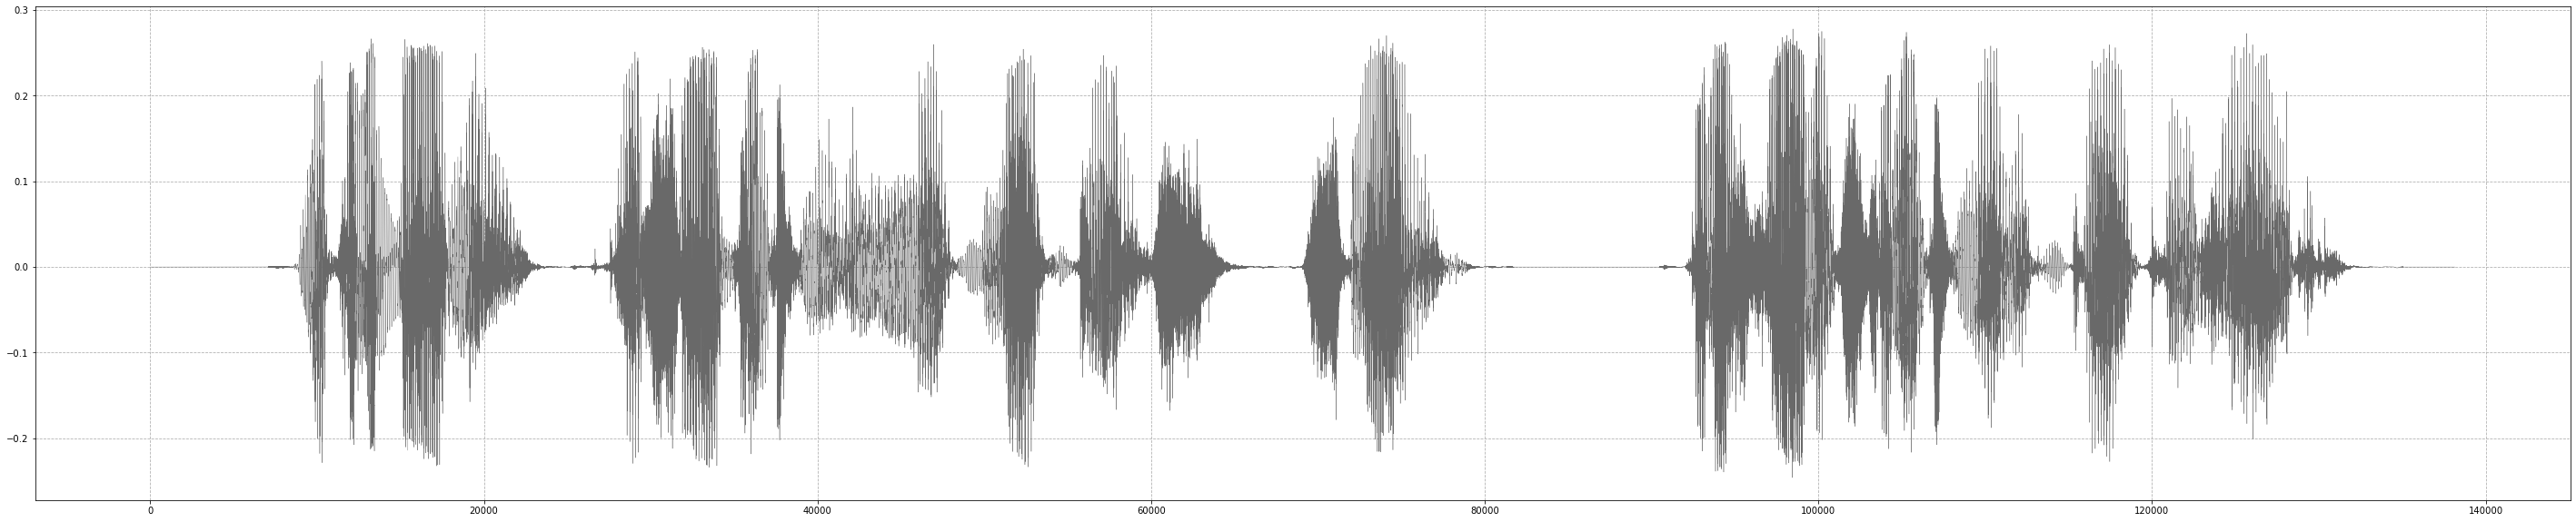

In [17]:
plot_curve((source_.view(-1)).detach().numpy())# original output

###  nosie without fading

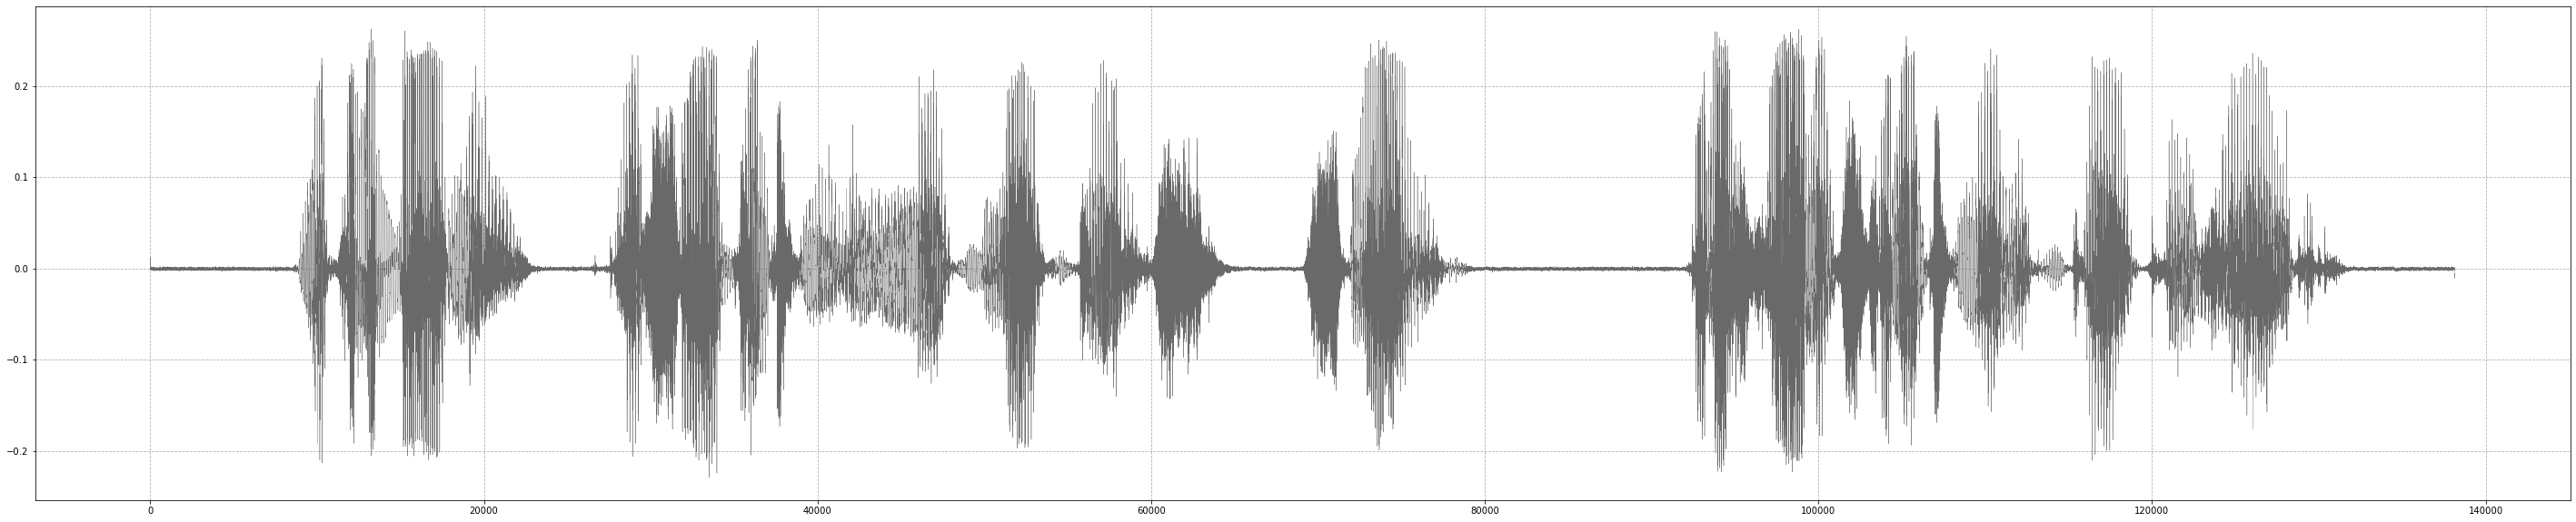

In [55]:
plot_curve((x_.view(-1)).detach().numpy())# original output

### 0.8 x amplitude    casued by fading

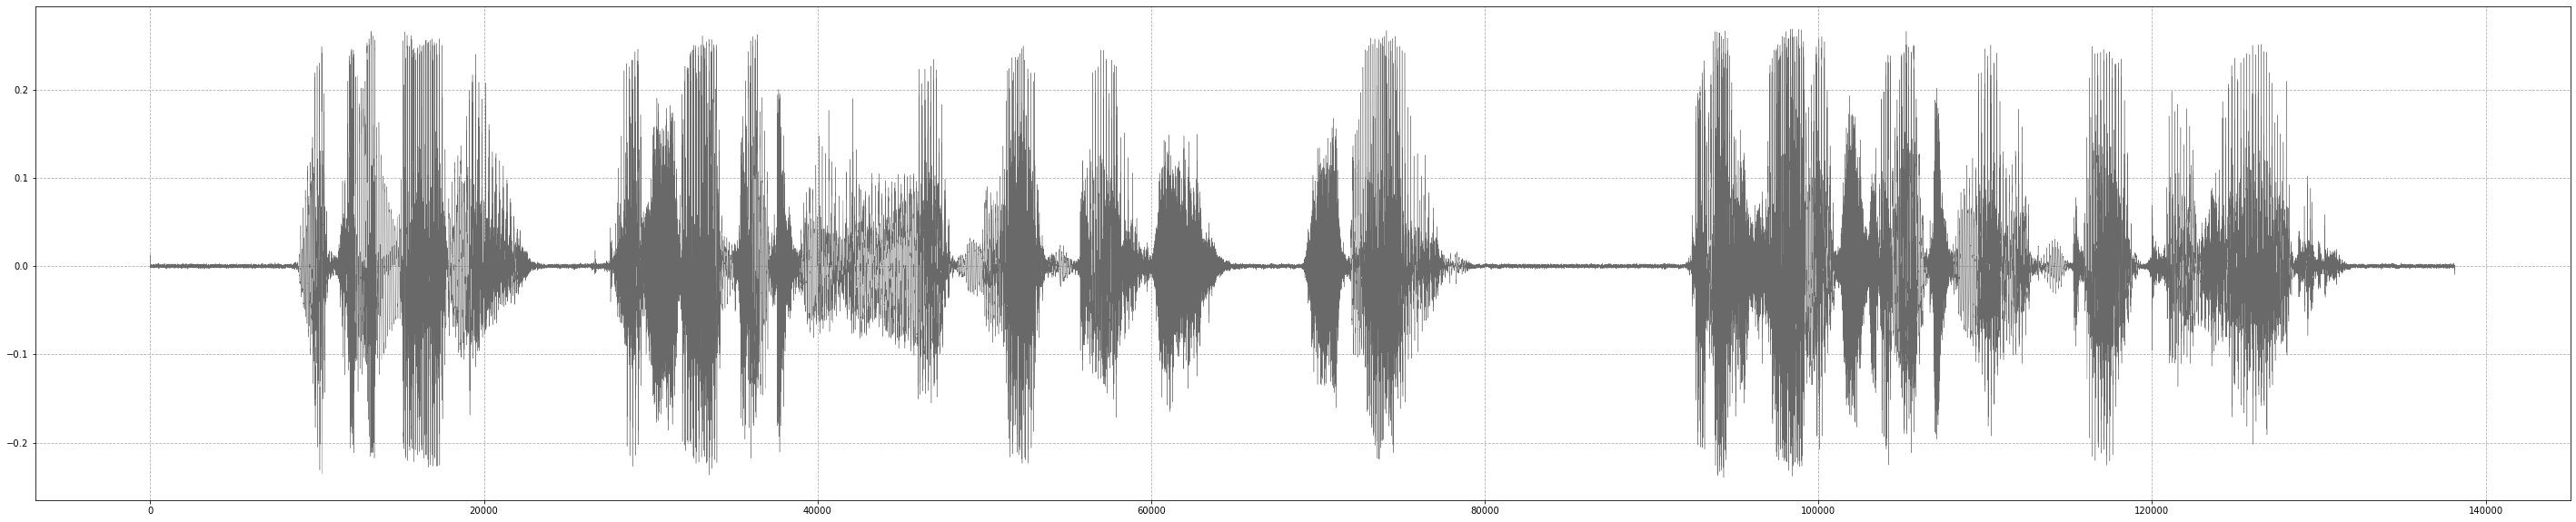

In [60]:
plot_curve((x_.view(-1)).detach().numpy())# original output

### 0.5 x amplitude    casued by fading

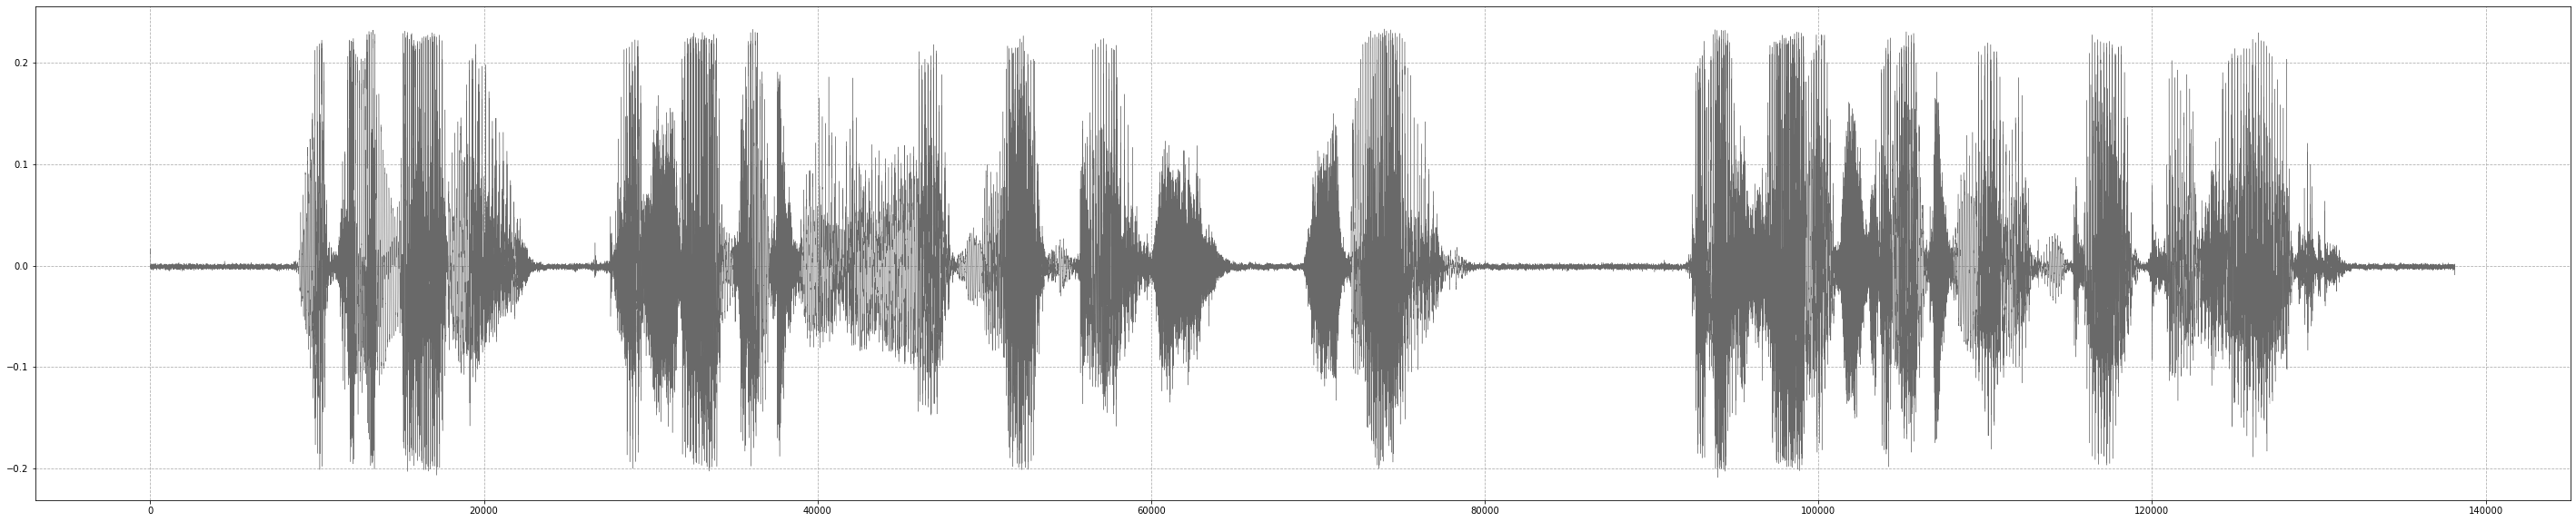

In [62]:
plot_curve((x_.view(-1)).detach().numpy())# original output

### 0.4 x amplitude    casued by fading

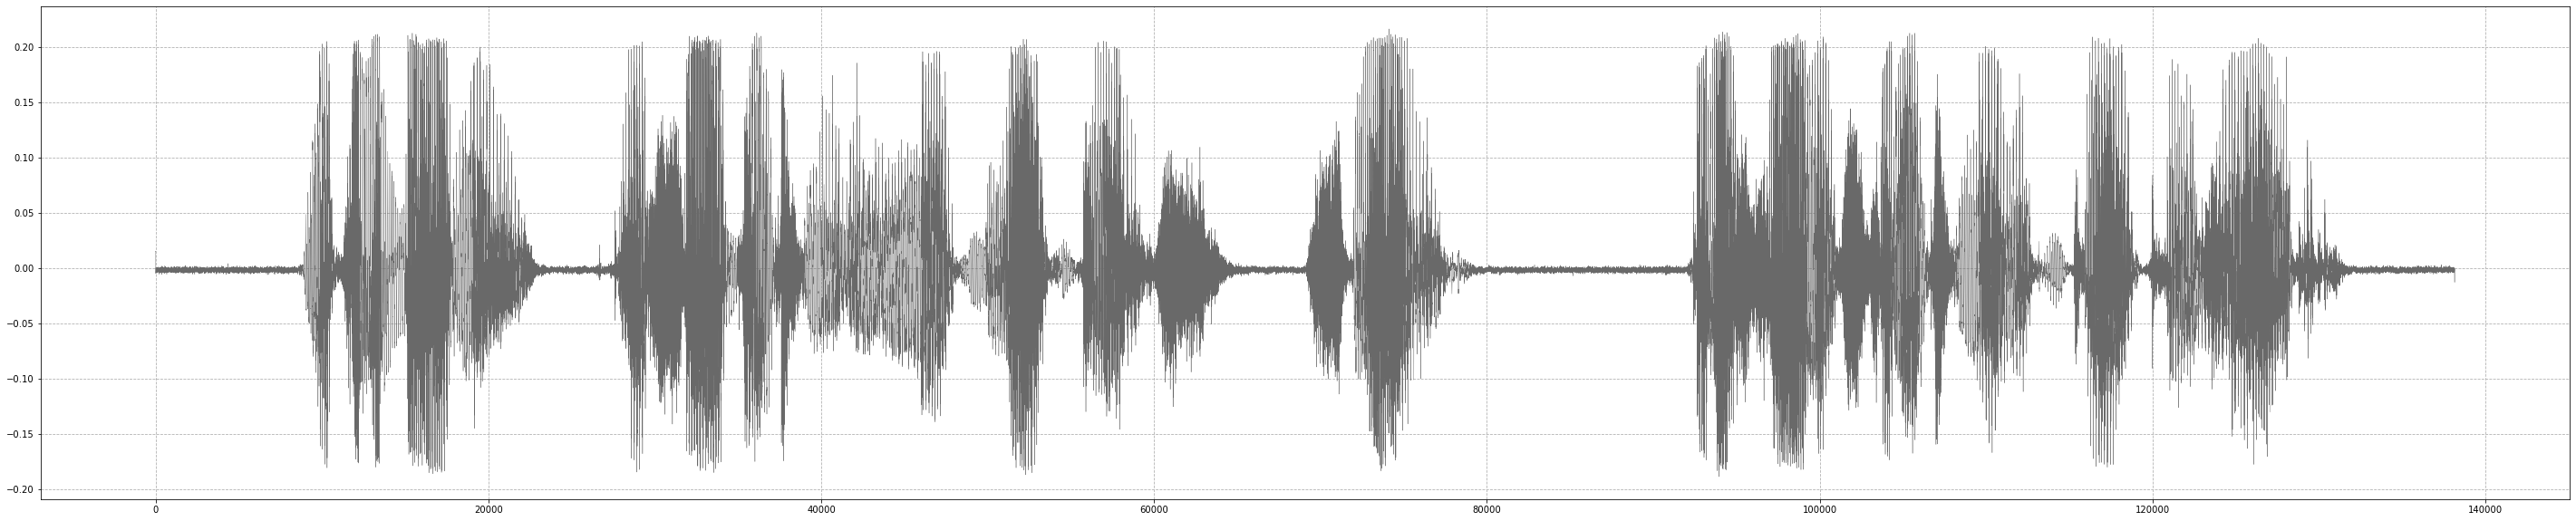

In [64]:
plot_curve((x_.view(-1)).detach().numpy())# original output

### 0.3 x amplitude    casued by fading


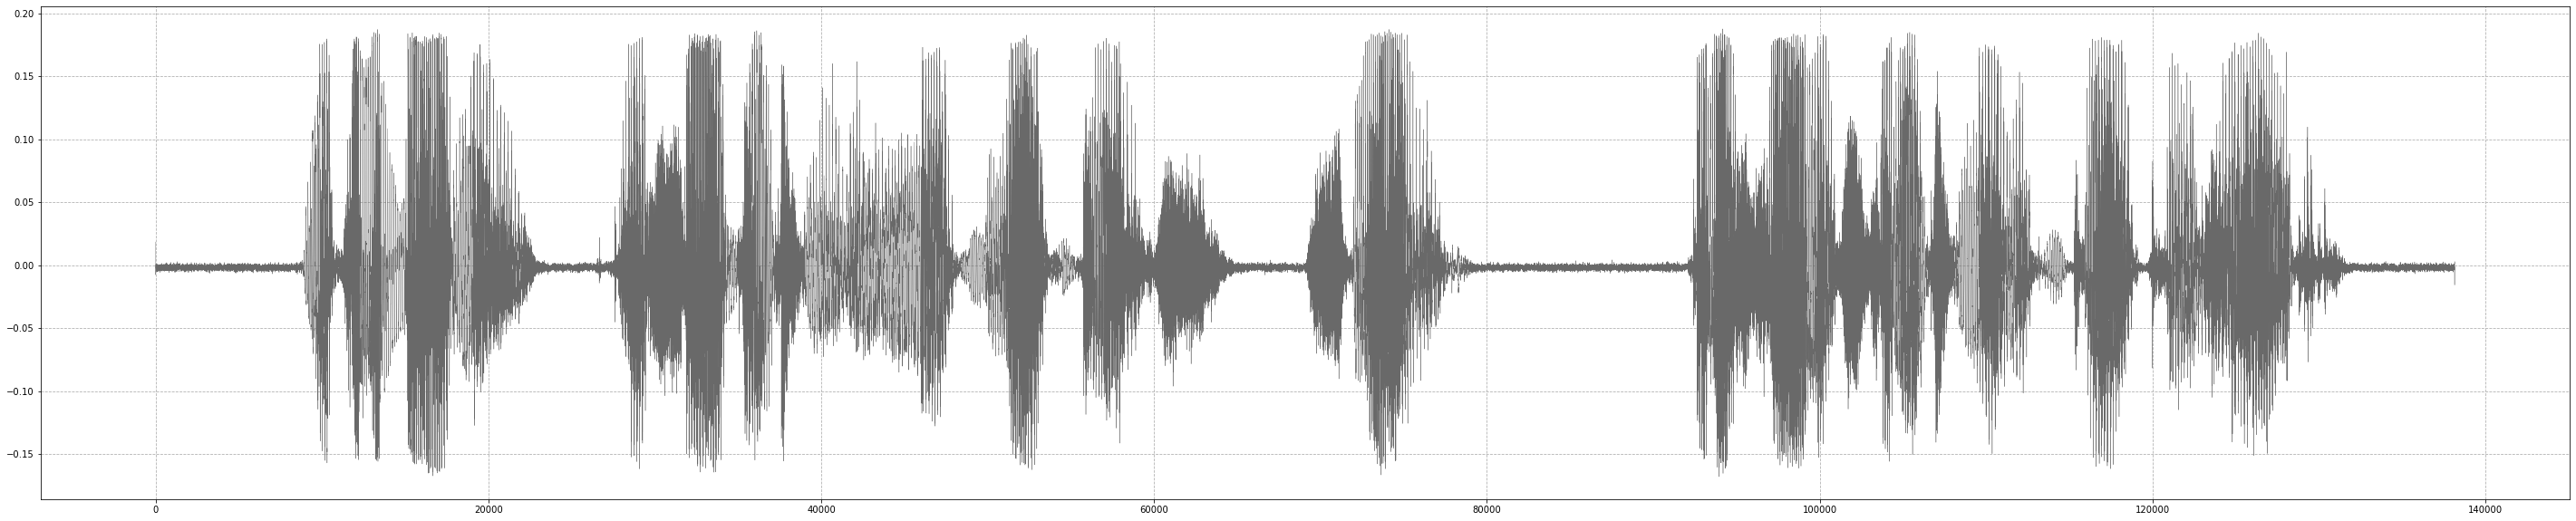

In [66]:
plot_curve((x_.view(-1)).detach().numpy())# original output

### 0.2 x amplitude    casued by fading

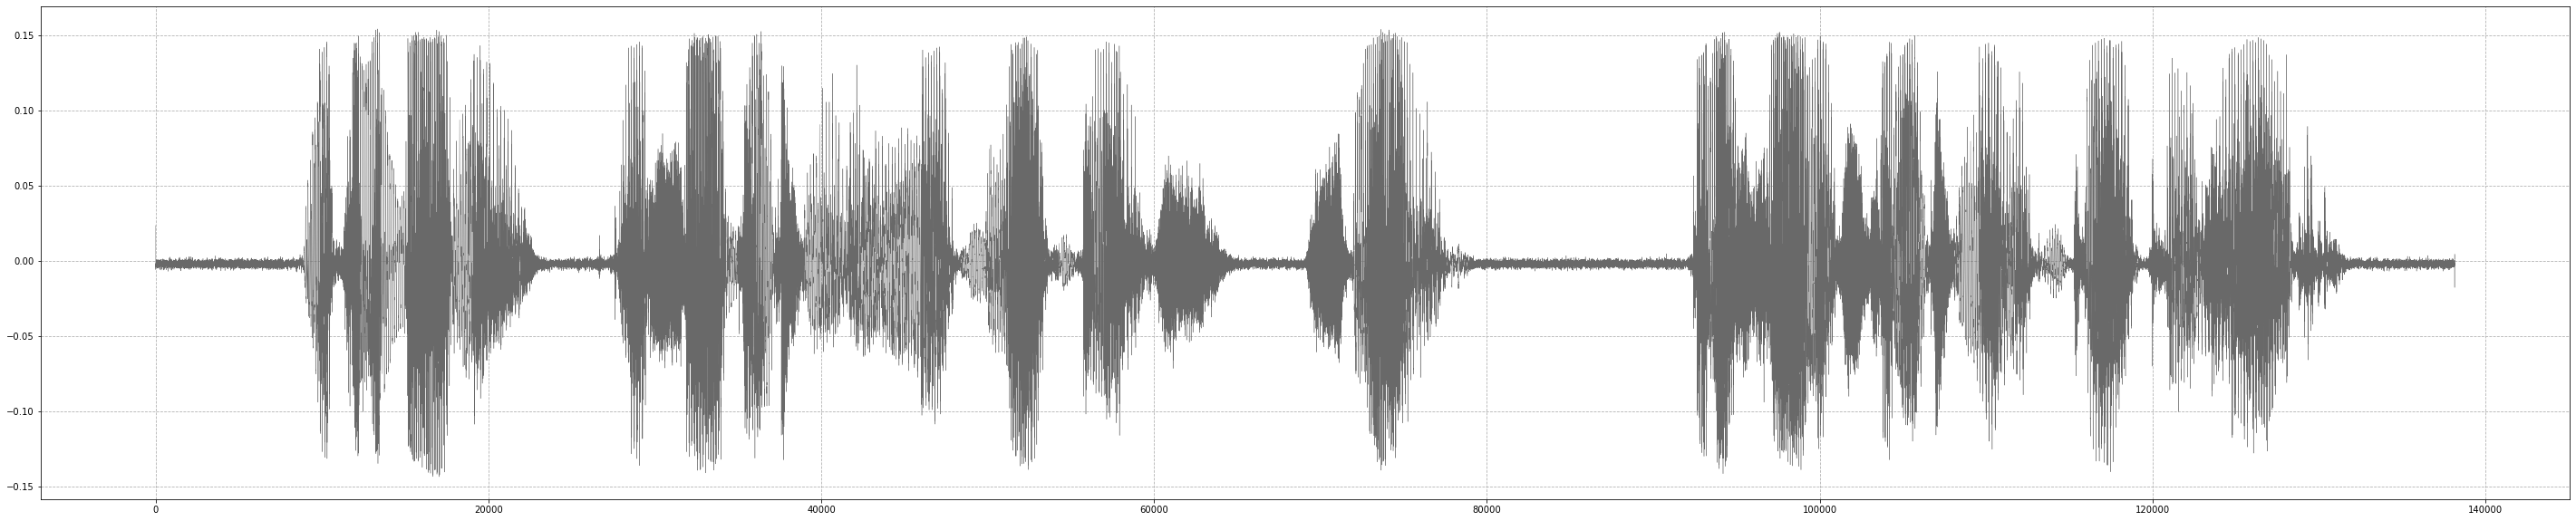

In [68]:
plot_curve((x_.view(-1)).detach().numpy())# original output

### 0.1 x amplitude    casued by fading

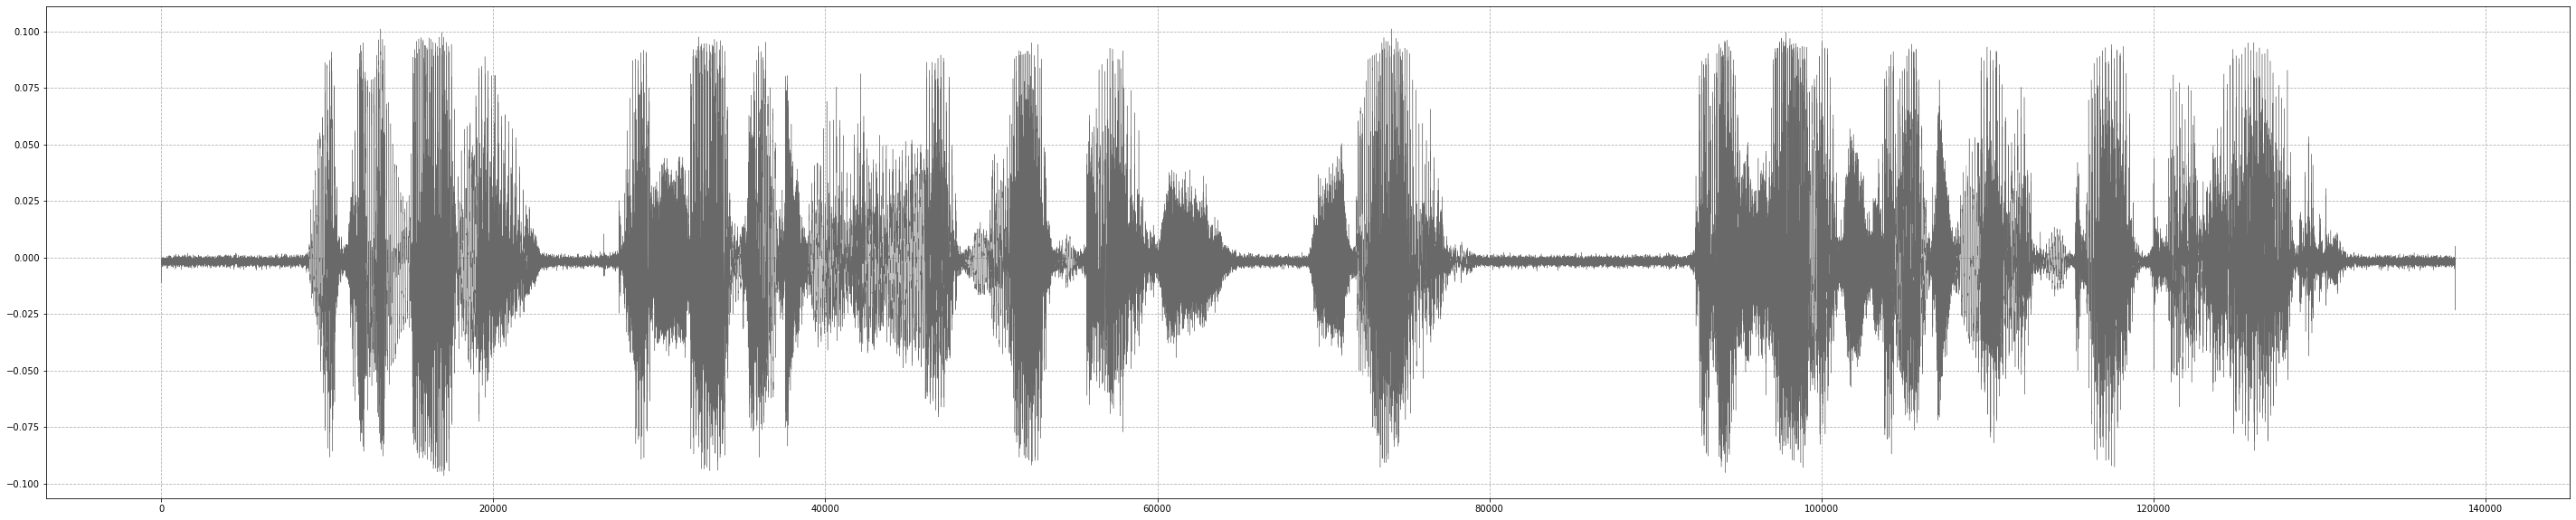

In [70]:
plot_curve((x_.view(-1)).detach().numpy())# original output

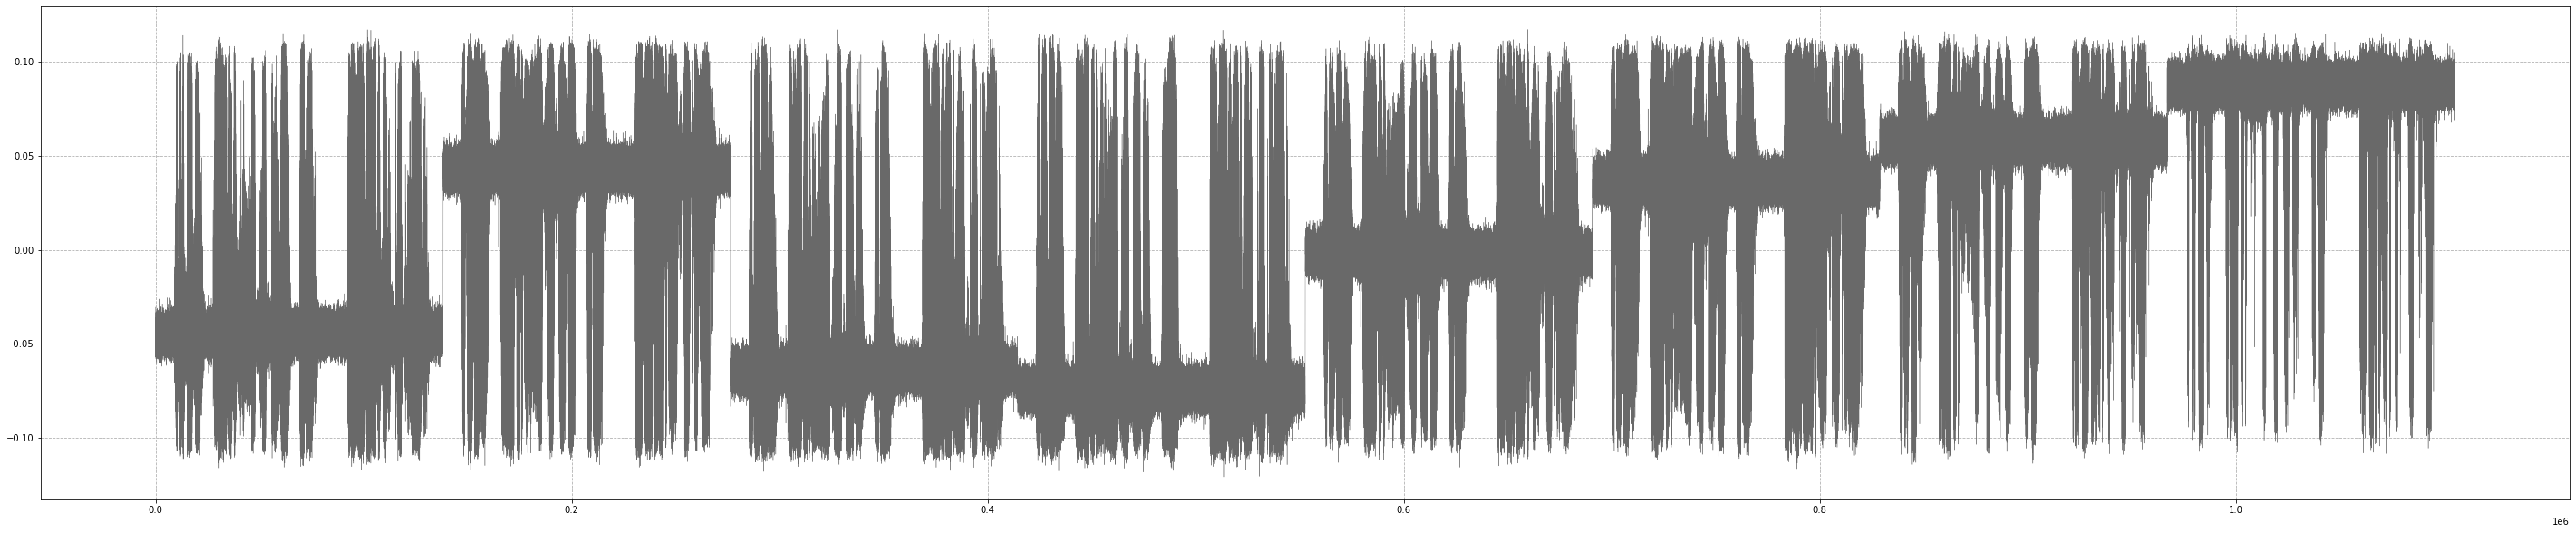

In [89]:
plot_curve((Y.view(-1)).detach().numpy())# original output

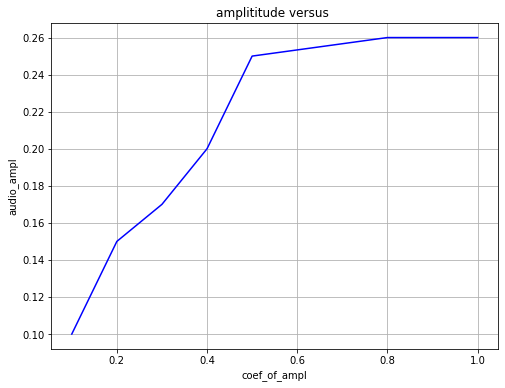

In [87]:
plt.figure(1,figsize=(8,6))
plt.title('amplititude versus ')
plt.xlabel('coef_of_ampl')
plt.ylabel('audio_ampl')
plt.plot(fading,amplit,'b-')
plt.grid()

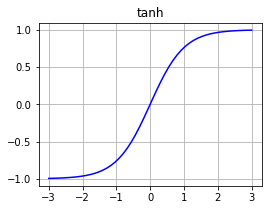

In [49]:
import matplotlib.pyplot as plt
import numpy as np

xx=np.linspace(-3,3)
plt.figure(1,figsize=(4,3))

y_tanh=(1-np.exp(-2*xx))/(1+np.exp(-2*xx))
plt.plot(xx,y_tanh,'b-')
plt.title('tanh')
plt.grid()


In [72]:
fading = [1, 0.8, 0.5, 0.4, 0.3, 0.2, 0.1]
ones = [1]*7
amplit = [0.26, 0.26, 0.25, 0.20, 0.17, 0.15, 0.1 ]